# TP2 - Machine Leaning 2
---
MOUSSA DIEME ISE 2

>Consigne 
 - Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc) 
- Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)
-  Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)
- Faire l'analyse des personnas pour le meilleur modèle
- Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)
---


## Import librairies

In [172]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer


## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [173]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [174]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

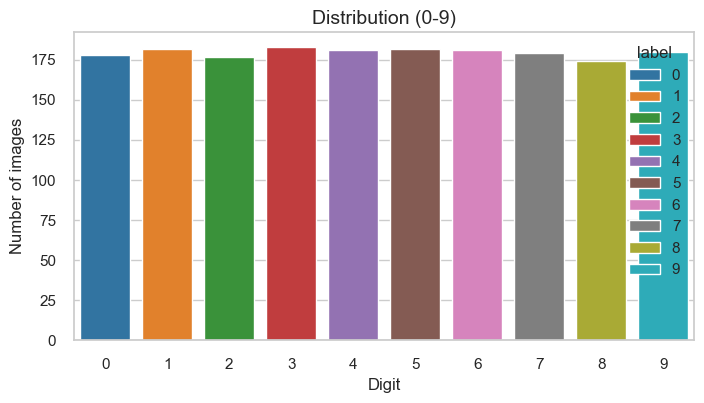

In [175]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, hue='label', palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

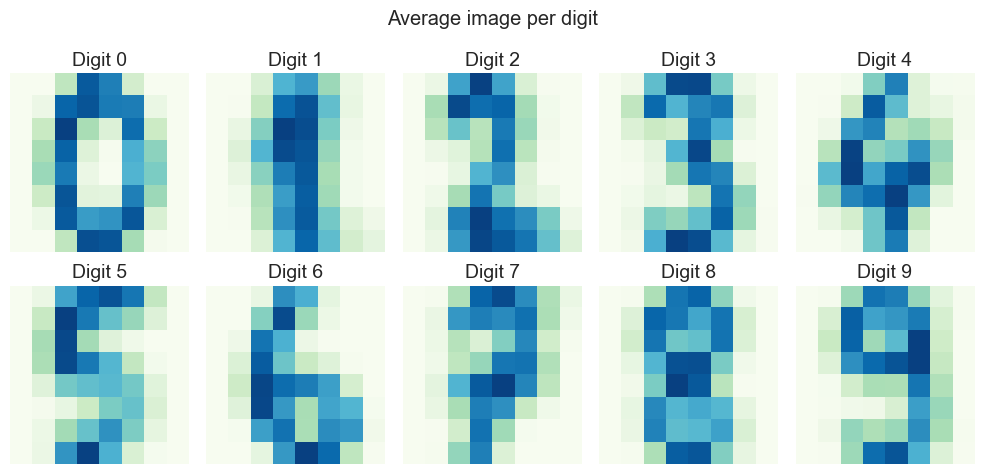

In [176]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='GnBu')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

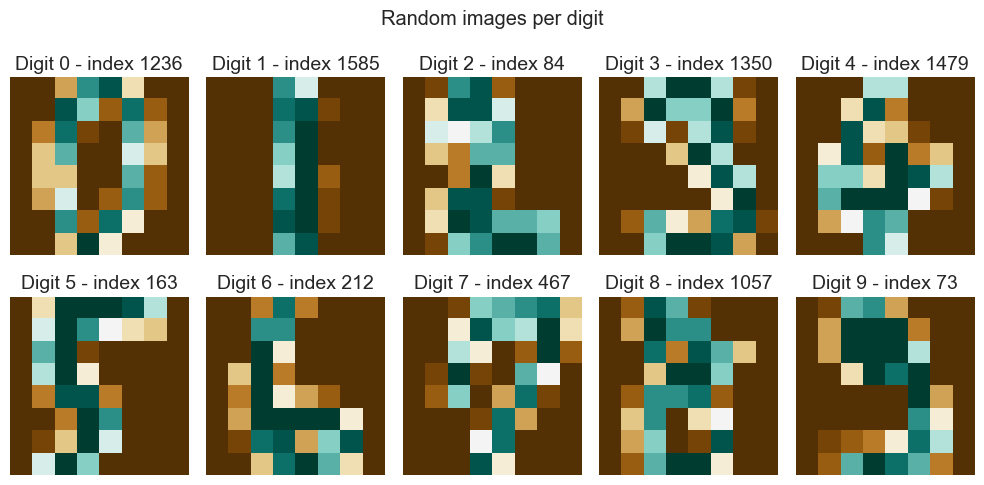

In [177]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='BrBG')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

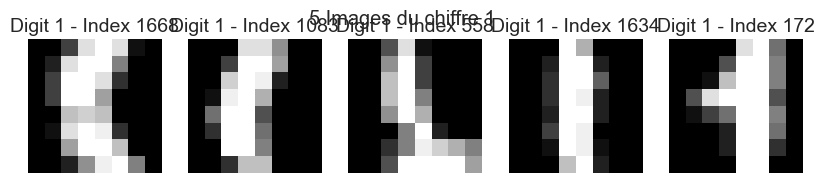

In [178]:
def show_digit_images(digit, n=5):
    """
    Affiche n images d'un chiffre spécifique du dataset digits.

    Paramètres :
    - digit : le chiffre à afficher (de 0 à 9).
    - n : nombre d'images à afficher.
    """
    idxs = np.random.choice(np.where(labels == digit)[0], size=n, replace=False)
    
    fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
    for i, idx in enumerate(idxs):
        axs[i].imshow(images[idx], cmap='gray')
        axs[i].set_title(f"Digit {digit} - Index {idx}")
        axs[i].axis('off')

    plt.suptitle(f"{n} Images du chiffre {digit}")
    plt.show()

show_digit_images(1, n=5)

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [179]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1797,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [180]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=7, random_state=221)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=7, random_state=221)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.060s	4648	0.738	0.746	0.742	0.668	0.183
random   	0.038s	4647	0.741	0.750	0.745	0.669	0.183
PCA-based	0.014s	4647	0.744	0.753	0.749	0.673	0.183
__________________________________________________________________________________


## Optimal number of clusters

In [181]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

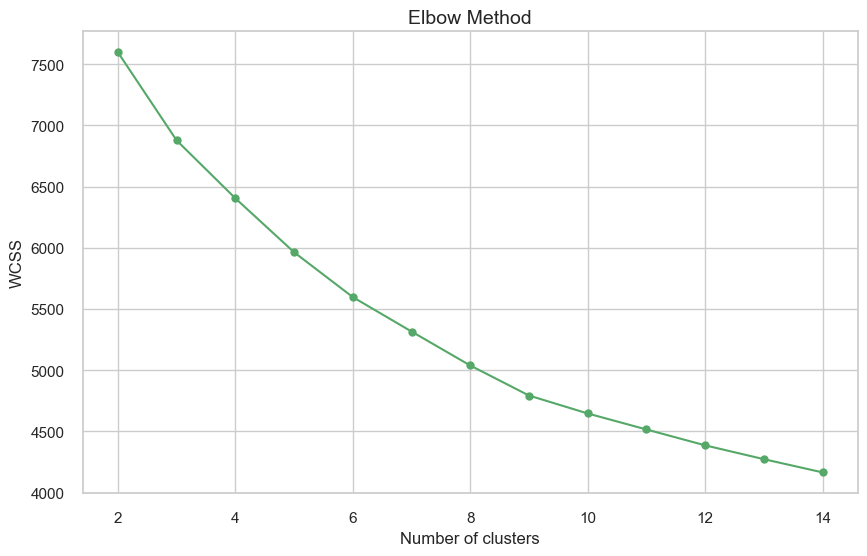

In [182]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

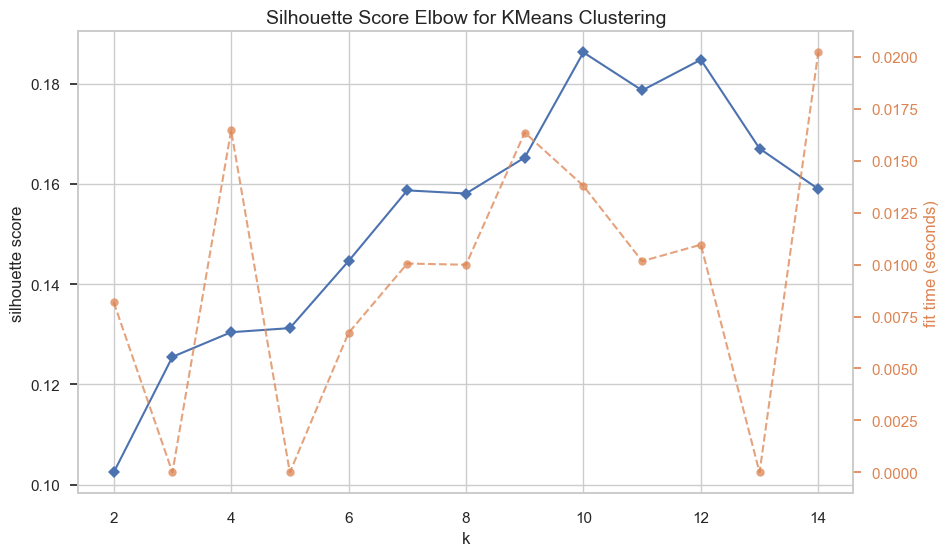

In [183]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [184]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [185]:
pd.DataFrame(reduced_data).head()

,0,1
0,-1.259466,-21.274883
1,7.957611,20.768699
2,6.991923,9.955986
3,-15.906105,-3.332464
4,23.306867,-4.269061


In [186]:
data["cluster"] = kmean_labels
data[['label','cluster']].head()

,label,cluster
0,0,7
1,1,0
2,2,8
3,3,4
4,4,2


In [187]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,88,1,0,8,0,0,20,4,0
1,0,0,115,43,0,3,0,1,4,8
2,1,2,0,0,149,2,29,0,1,0
3,1,29,34,11,0,46,0,1,69,17
4,0,0,3,96,0,1,0,0,0,39
5,0,9,7,12,3,24,0,117,24,9
6,15,0,0,0,16,5,143,0,0,1
7,157,0,0,0,0,6,7,0,0,0
8,0,48,13,0,5,49,2,40,64,10


In [188]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    1
1    2
2    4
3    8
4    3
5    7
6    6
7    0
8    8
9    9
dtype: int64


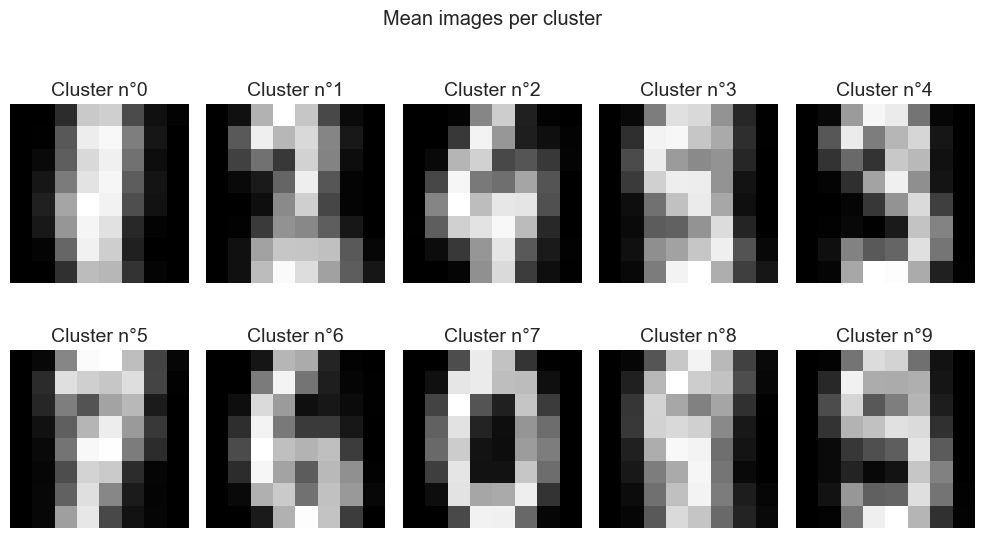

In [189]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

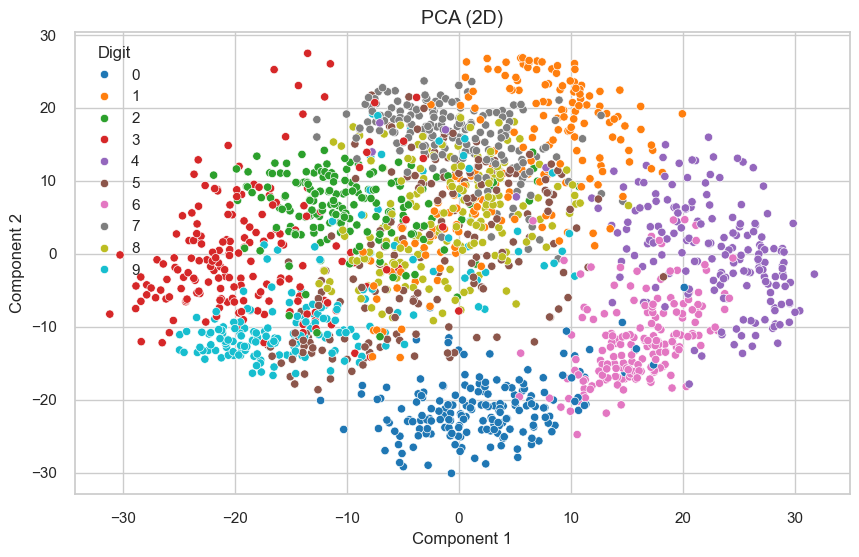

In [190]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


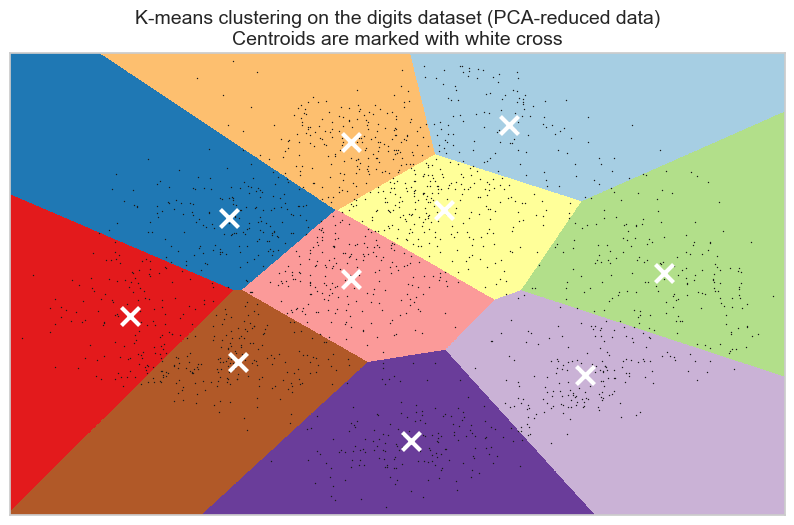

In [191]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

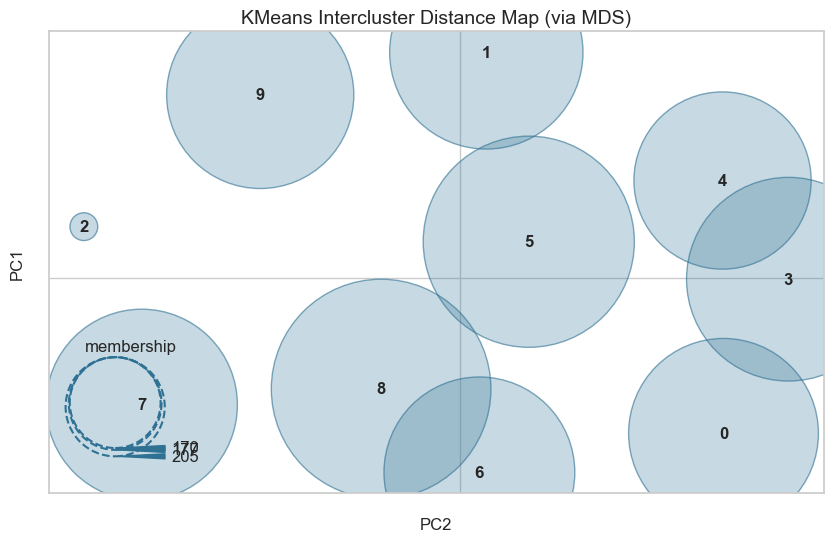

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [192]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [193]:
# Initialize

from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


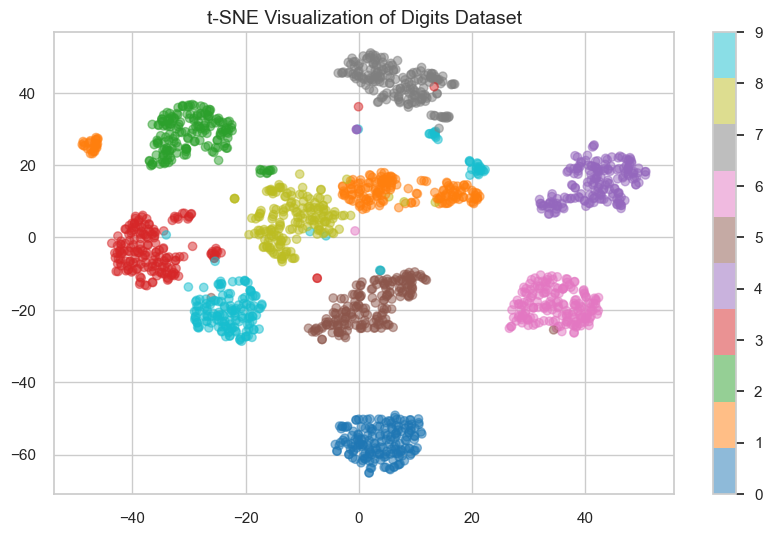

In [194]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.title("t-SNE Visualization of Digits Dataset")
plt.show()

---

# TP --- 
>Ma contribution

In [195]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid


## Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc) 

In [196]:
# Nous allons legerement modifier bench_k_mean pour  y inclure un return afin de capter ses sorties
# output : une liste
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1797, # On prend tous le monde
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results
    

In [197]:

# Standardisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=222, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.076s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.053s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.052s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.045s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.072s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.099s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.112s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.109s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.103s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.094s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-me

In [198]:
df.iloc[0]['params']

{'init': 'k-means++',
 'max_iter': 100,
 'n_clusters': 10,
 'n_init': 5,
 'tol': 0.001}

In [199]:
def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)


In [200]:
df_viz.head()

,init,max_iter,n_clusters,n_init,tol,name,fit_time,inertia,homogeneity,completeness,v_measure,ari,silhouette
0,k-means++,100,10,5,1.000000e-03,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.075513,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
1,k-means++,100,10,5,1.000000e-05,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.053472,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
2,k-means++,100,10,5,1.000000e-06,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.052421,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
3,k-means++,100,10,5,1.000000e-07,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.044956,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
4,k-means++,100,10,5,1.000000e-10,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.071901,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568


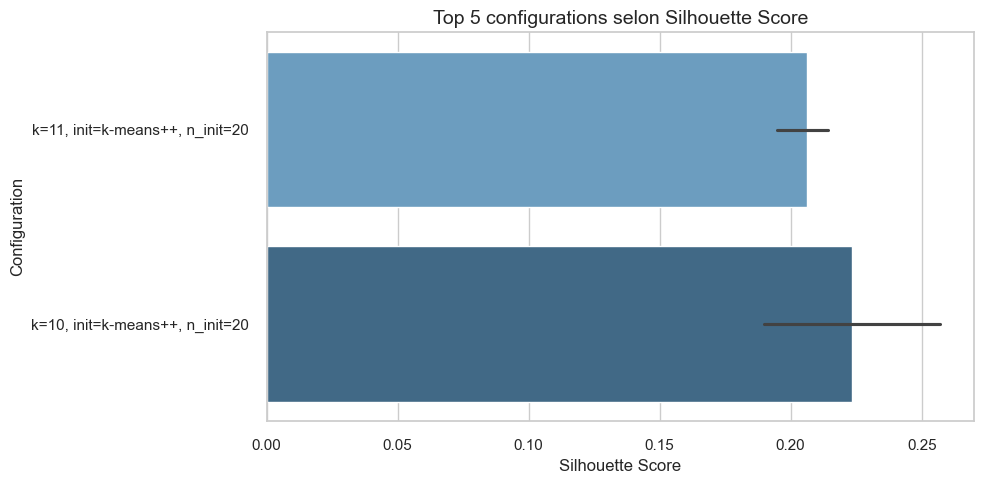

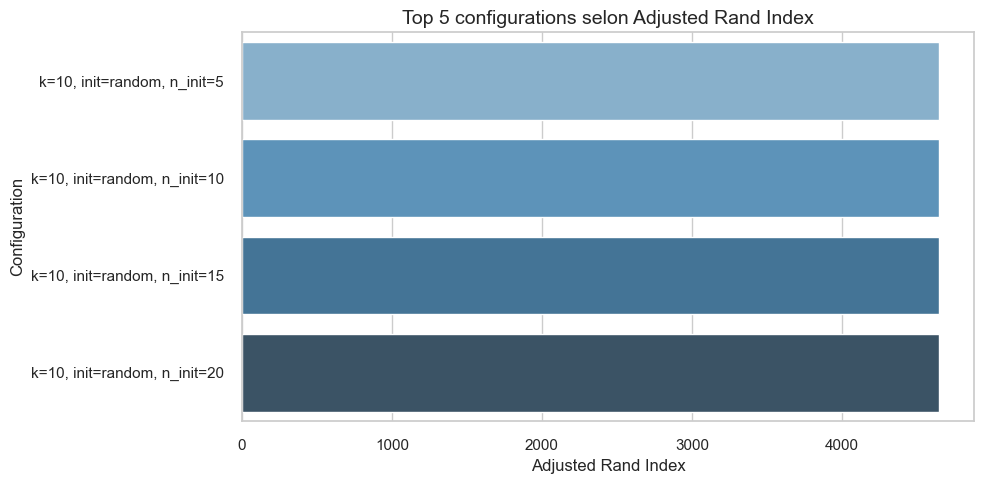

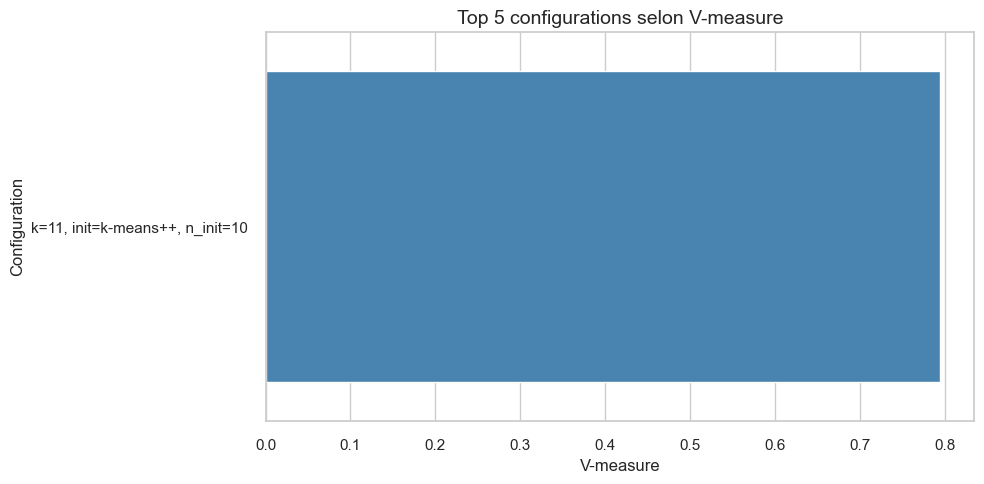

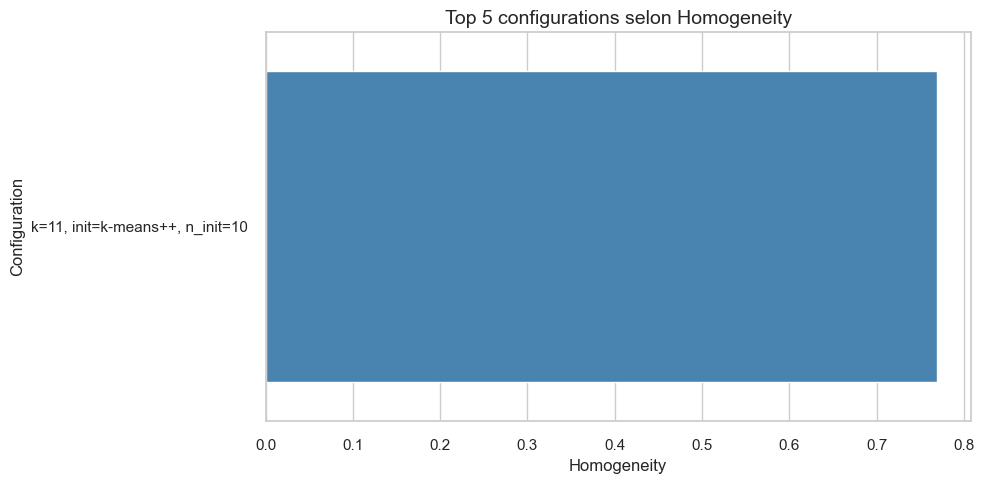

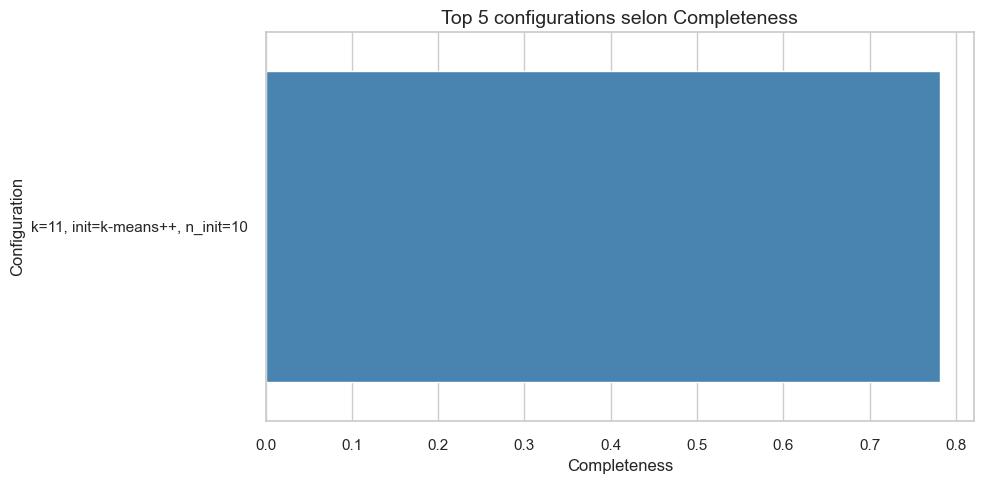

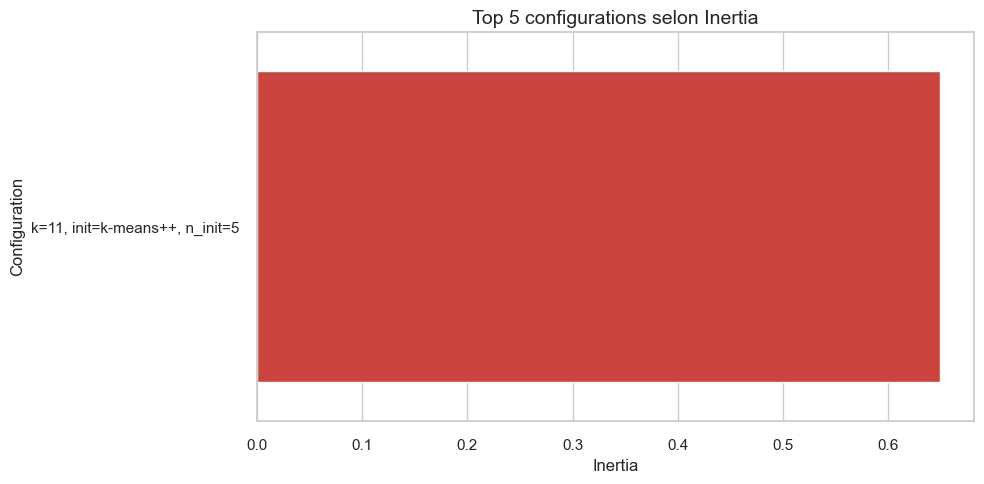

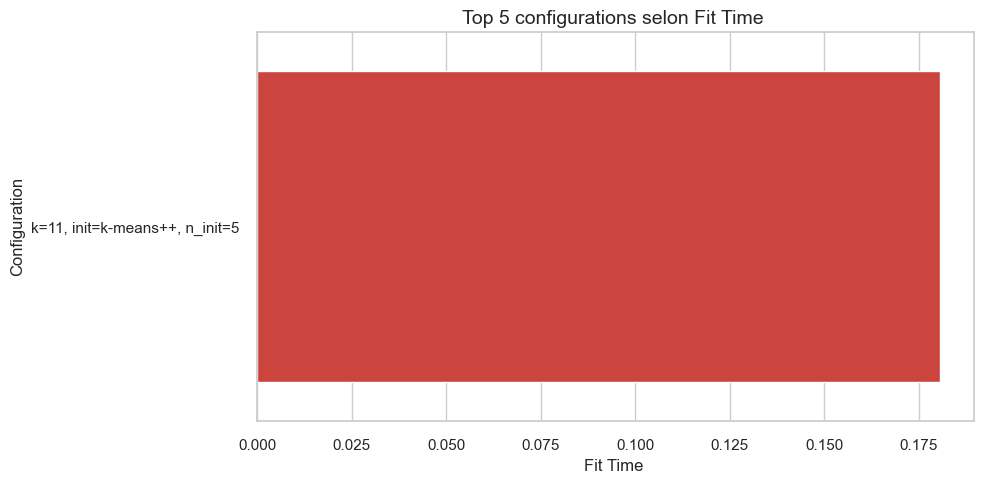

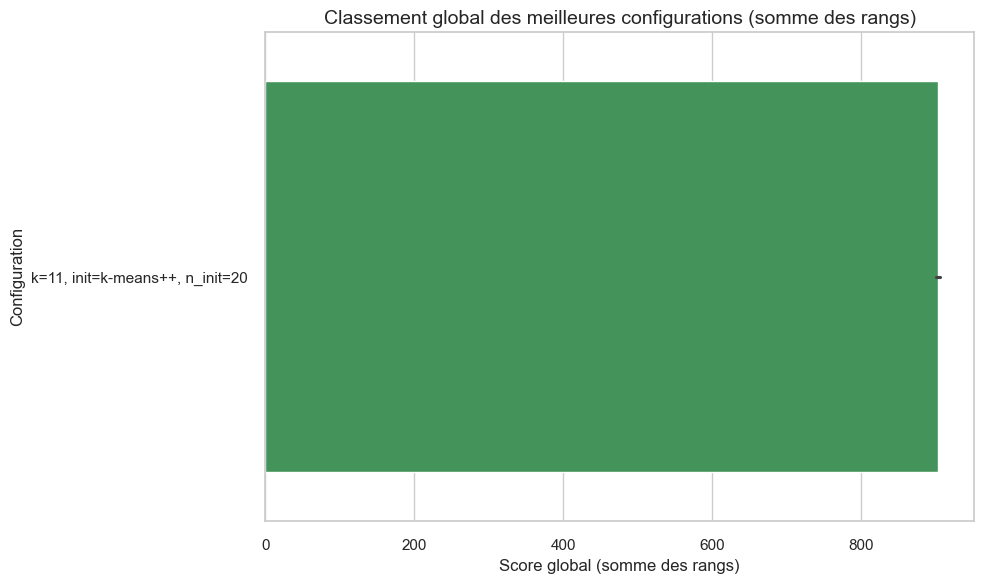

In [201]:
# Si il y a des exequo alors seul le premier est affiche ce qui fait qu'on a pas systematiquement 5 graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
params_df = df["params"].apply(pd.Series)
df_viz = pd.concat([params_df, results_df], axis=1)

# afficher les top configurations
def plot_top_configs(metric, label, ascending):
    threshold = df_viz[metric].sort_values(ascending=ascending).iloc[top_n - 1]
    if ascending:
        top_df = df_viz[df_viz[metric] <= threshold].copy()
    else:
        top_df = df_viz[df_viz[metric] >= threshold].copy()

    top_df["config"] = top_df.apply(
        lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
    )
    
    # Tracé
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_df,
        y="config",
        hue="config",
        x=metric,
        palette="Blues_d" if not ascending else "Reds_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()

for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [202]:
#Top 5 global
print("Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)")
display(ranks_sorted[["config", "total_rank"] + list(metrics_info.keys())].head(top_n))


Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)


,config,total_rank,silhouette,ari,v_measure,homogeneity,completeness,inertia,fit_time
0,"k=11, init=k-means++, n_init=20",899.0,8.0,251.0,26.0,26.0,26.0,226.0,336.0
1,"k=11, init=k-means++, n_init=20",901.0,10.0,251.0,26.0,26.0,26.0,226.0,336.0
2,"k=11, init=k-means++, n_init=20",904.0,13.0,251.0,26.0,26.0,26.0,226.0,336.0
3,"k=11, init=k-means++, n_init=20",905.0,14.0,251.0,26.0,26.0,26.0,226.0,336.0
4,"k=11, init=k-means++, n_init=20",908.0,27.0,251.0,26.0,26.0,26.0,226.0,326.0


In [203]:
# on s'en servira lors de la comparaison avec ou sans pca
best_silhouette_config = df_viz.loc[df_viz["silhouette"].idxmax()]

In [204]:
best_config = ranks_sorted.iloc[0] 
best_config

silhouette                                  8.0
ari                                       251.0
v_measure                                  26.0
homogeneity                                26.0
completeness                               26.0
inertia                                   226.0
fit_time                                  336.0
config          k=11, init=k-means++, n_init=20
total_rank                                899.0
Name: 0, dtype: object

Si on accorde le même poids à toutes les métriques, on obtient des clusters avec un score de silhouette de 50, ce qui est plutôt faible.les groupes formés ne sont pas  bien séparés et  certains points pourraient être mal placés, ce qui entraîne un chevauchement entre les clusters.

Même si la séparation spatiale n’est pas parfaite, la structure globale des groupes fait du sens et correspond assez bien aux vraies classes. 
malgré cela, le score ari de 101 montre que la structure des clusters est assez cohérente avec les classes réelles, ce qui signifie que le regroupement est pertinent, même si spatialement il manque un peu de précision
le score de v-measure de 161 indique que l'homogénéité et la complétude sont bonnes, ce qui signifie que les clusters contiennent des points ayant des caractéristiques similaires et regroupent correctement les éléments d'une même classe
l'homogénéité et la complétude, toutes deux à 101, renforcent cette idée en démontrant que chaque cluster est bien défini et que les données proches en termes de caractéristiques sont bien regroupées .l'inertie, qui est de 141, montre que la dispersion des points autour des centres de clusters est modérée, ce qui peut expliquer pourquoi la séparation n'est pas parfaite. une inertie plus basse pourrait indiquer des groupes plus denses et mieux structurés.

globalement, même si le score de silhouette suggère que la séparation entre les clusters pourrait être améliorée, les autres métriques indiquent une bonne cohérence interne et une structuration efficace des données. Pour aller plus loins nous pouvons revenir sur le nombre de cluster que nous avons volontier fixé entre 10 et 11 pour cause de connaissance sur le dataset.

Le silhouette est vraiment faible malgres l'optimisaton



# - Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)

Nous allons refaire l'optimisation mais avec PCA sans chercher à visualiser nos données 

In [205]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

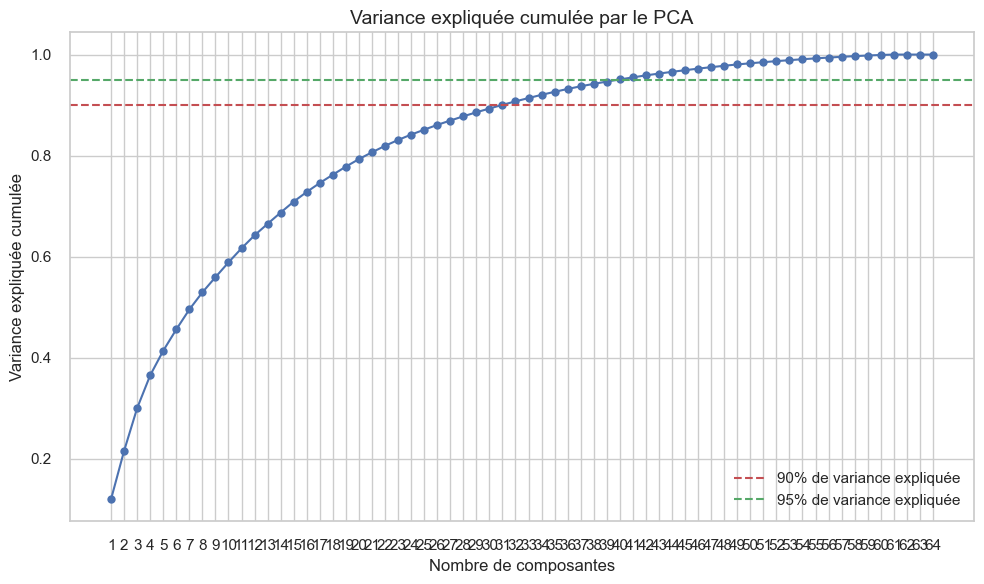

In [206]:
#PCA sans réduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#variance expliquée cumulée
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% de variance expliquée')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% de variance expliquée')
plt.title("Variance expliquée cumulée par le PCA")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [207]:
print(np.argmax(explained_variance >= 0.90) + 1)
n_components=np.argmax(explained_variance >= 0.90) + 1


31


In [208]:
# On refait une nouvelle ACP avec les n_components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


In [209]:

# Standardisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pca)
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=221, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.036s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.036s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.048s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.052s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.047s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.071s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.078s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.076s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.074s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.074s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-me

In [210]:
#copier_coller

def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)



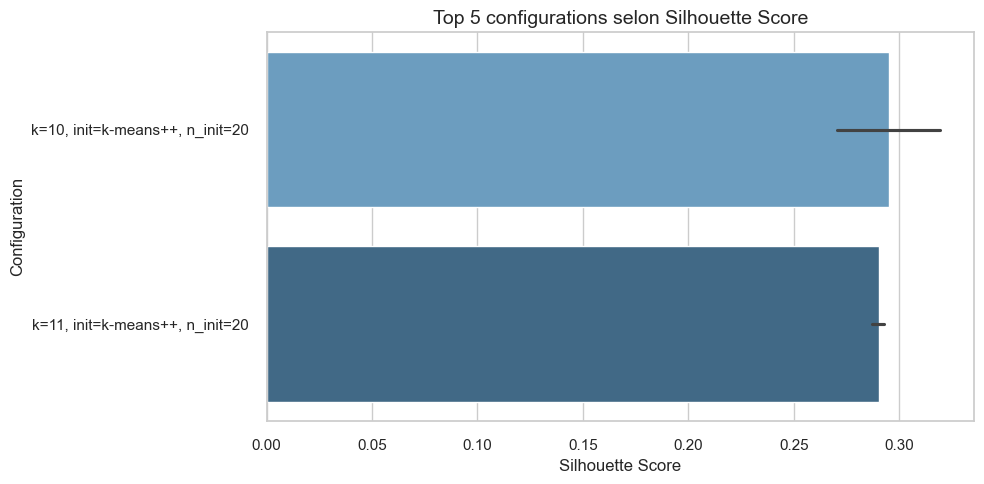

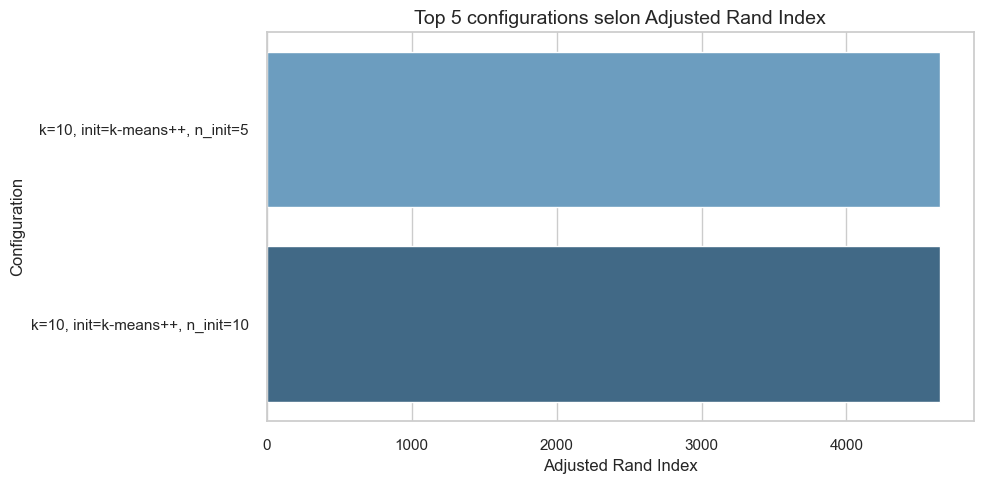

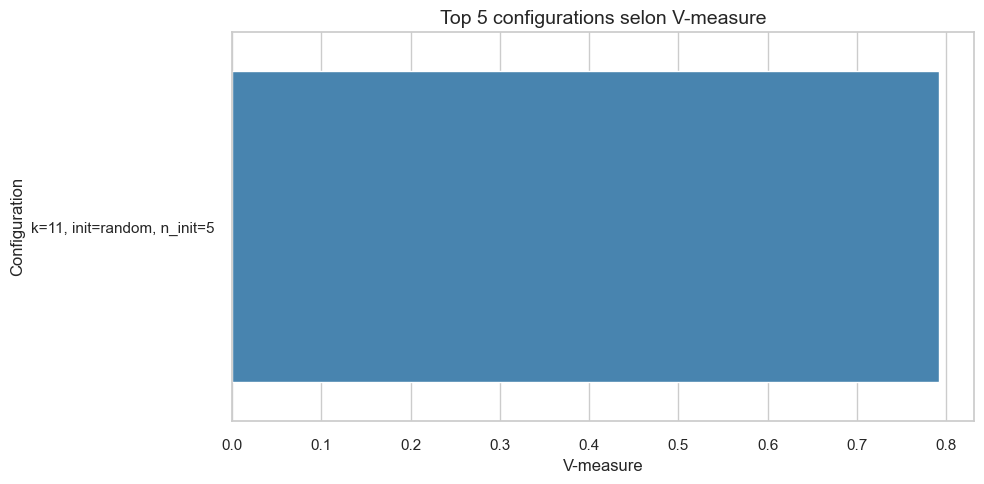

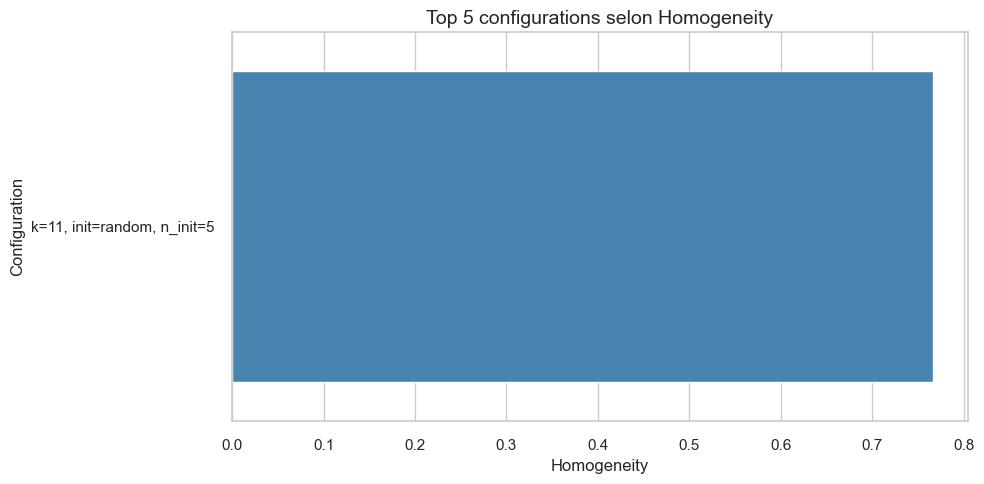

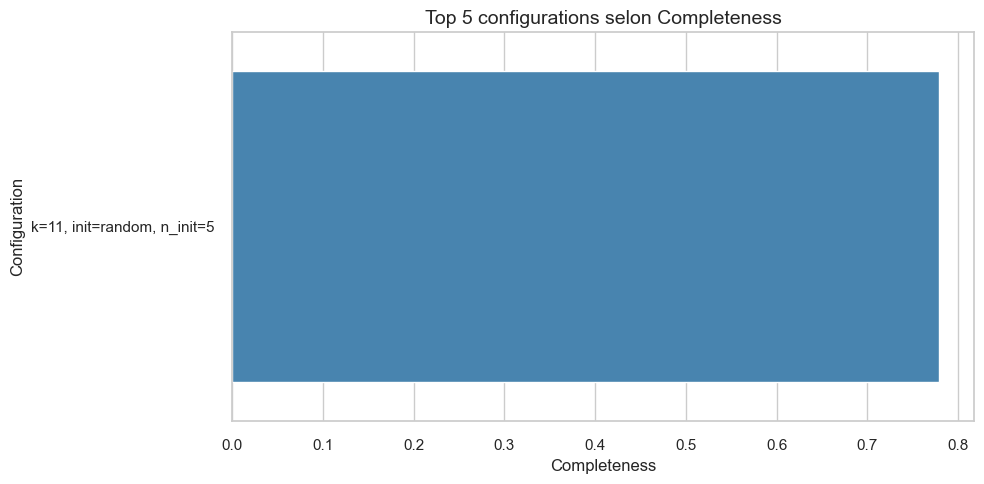

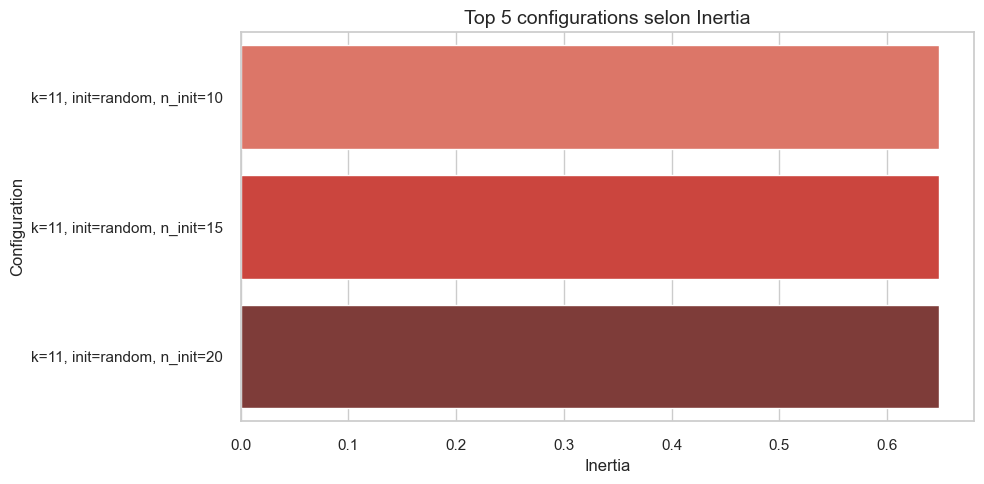

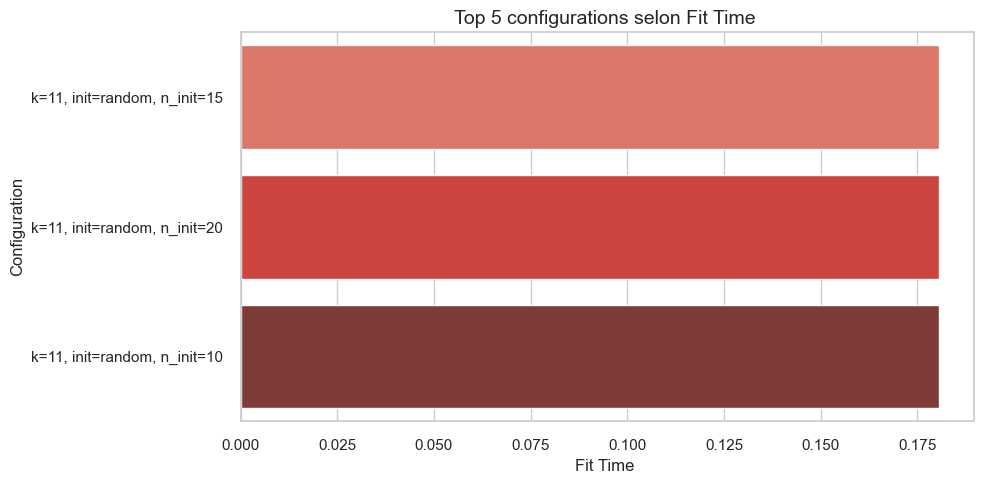

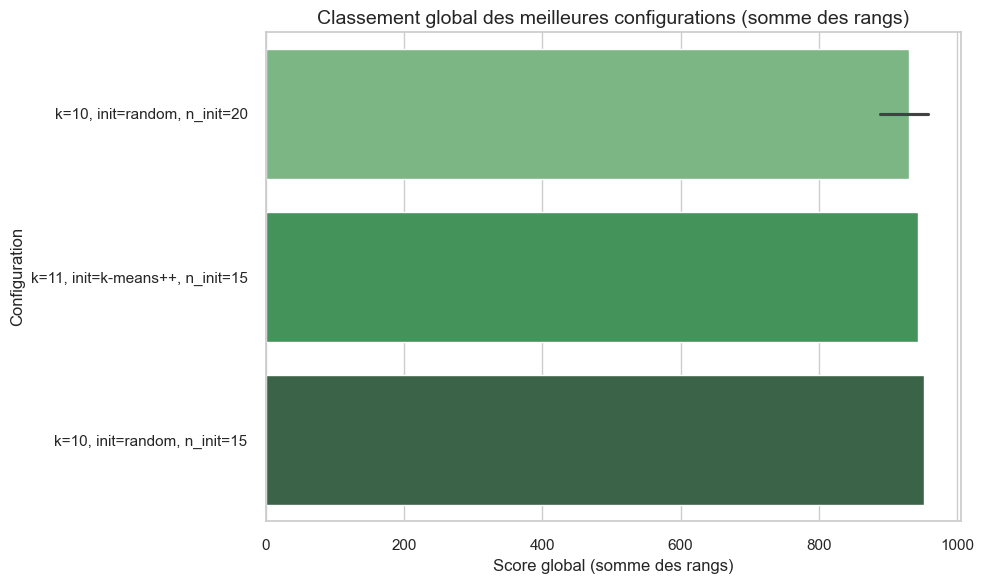

In [211]:
# Si il y a des exequo alors seul le premier est affiche ce qui fait qu'on a pas systematiquement 5 graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
params_df = df["params"].apply(pd.Series)
df_viz = pd.concat([params_df, results_df], axis=1)

# afficher les top configurations
def plot_top_configs(metric, label, ascending):
    threshold = df_viz[metric].sort_values(ascending=ascending).iloc[top_n - 1]
    if ascending:
        top_df = df_viz[df_viz[metric] <= threshold].copy()
    else:
        top_df = df_viz[df_viz[metric] >= threshold].copy()

    top_df["config"] = top_df.apply(
        lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
    )
    
    # Tracé
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_df,
        y="config",
        hue="config",
        x=metric,
        palette="Blues_d" if not ascending else "Reds_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()

for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [212]:
#Top 5 global
print("Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)")
display(ranks_sorted[["config", "total_rank"] + list(metrics_info.keys())].head(top_n))

Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)


,config,total_rank,silhouette,ari,v_measure,homogeneity,completeness,inertia,fit_time
0,"k=10, init=random, n_init=20",888.0,10.0,126.0,201.0,126.0,126.0,176.0,123.0
1,"k=11, init=k-means++, n_init=15",943.0,12.0,301.0,26.0,26.0,26.0,301.0,251.0
2,"k=10, init=random, n_init=20",947.0,69.0,126.0,201.0,126.0,126.0,176.0,123.0
3,"k=10, init=random, n_init=15",952.0,74.0,126.0,201.0,126.0,126.0,176.0,123.0
4,"k=10, init=random, n_init=20",957.0,79.0,126.0,201.0,126.0,126.0,176.0,123.0


In [ ]:
best_config_pca = ranks_sorted.iloc[0] 
best_config_pca
# On ne fait plus l'agregation car avec pca on a un silouette score de 10% presque pareil que 8%

silhouette                              10.0
ari                                    126.0
v_measure                              201.0
homogeneity                            126.0
completeness                           126.0
inertia                                176.0
fit_time                               123.0
config          k=10, init=random, n_init=20
total_rank                             888.0
Name: 0, dtype: object

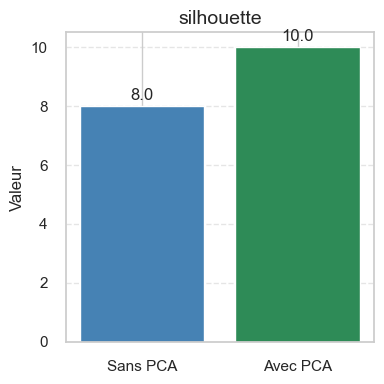

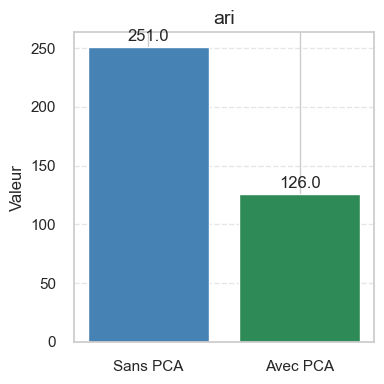

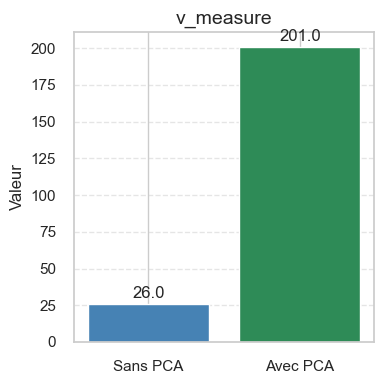

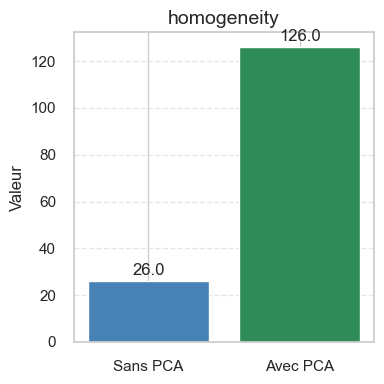

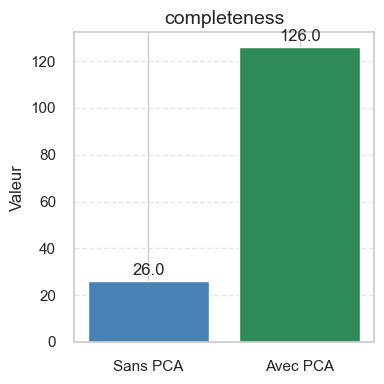

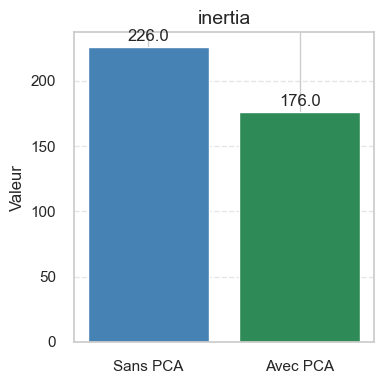

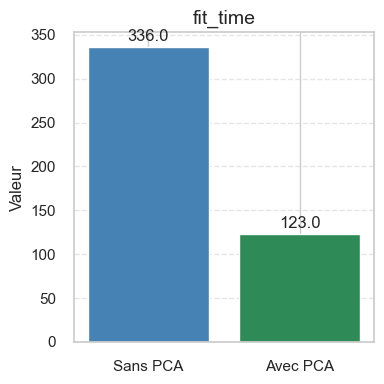

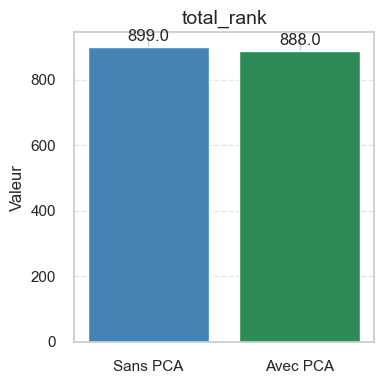

In [214]:
df = pd.DataFrame({"Sans PCA": best_config, "Avec PCA": best_config_pca})
df_numeric = df.drop(index="config")  # supprimer le champ non numérique

#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans PCA", "Avec PCA"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Les deux approches sont sensiblement equivalente mais on perd en silhouette score; On va changer d'approche on va prendre le best config en silhouette score.

In [215]:
best_silhouette_config_pca = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config_pca


init                                                    k-means++
max_iter                                                      200
n_clusters                                                     10
n_init                                                         20
tol                                                       0.00001
name            k=10, init=k-means++, n_init=20, max_iter=200,...
silhouette                                               0.319425
ari                                                    4647.17016
v_measure                                                0.737163
homogeneity                                              0.745314
completeness                                             0.741216
inertia                                                  0.668133
fit_time                                                  0.18238
Name: 56, dtype: object

In [216]:
best_silhouette_config

init                                                    k-means++
max_iter                                                      200
n_clusters                                                     10
n_init                                                         20
tol                                                           0.0
name            k=10, init=k-means++, n_init=20, max_iter=200,...
silhouette                                               0.257097
ari                                                   4647.114323
v_measure                                                0.738564
homogeneity                                              0.746679
completeness                                             0.742599
inertia                                                  0.671828
fit_time                                                 0.182482
Name: 58, dtype: object

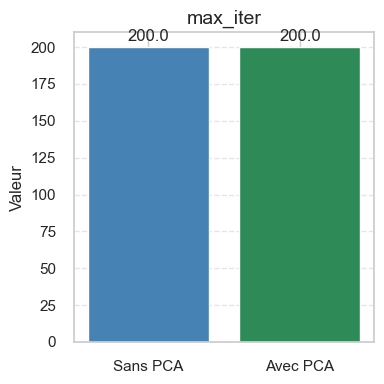

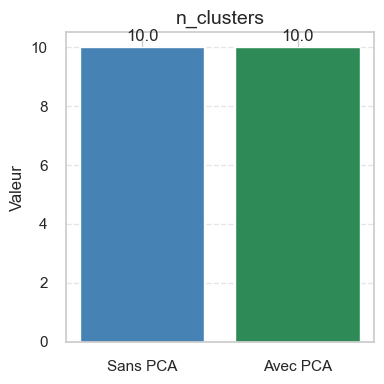

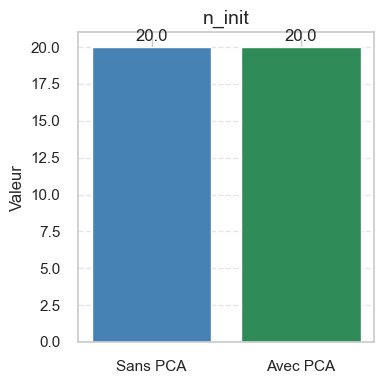

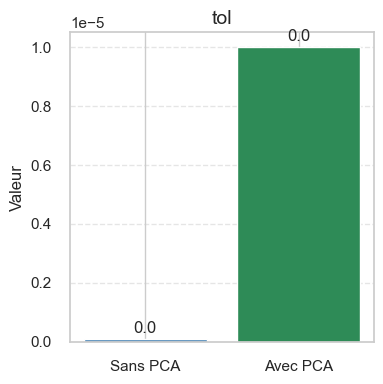

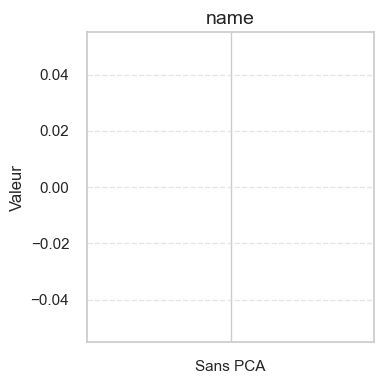

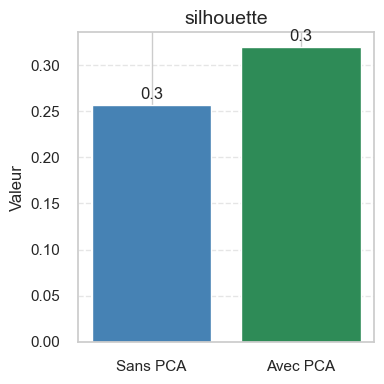

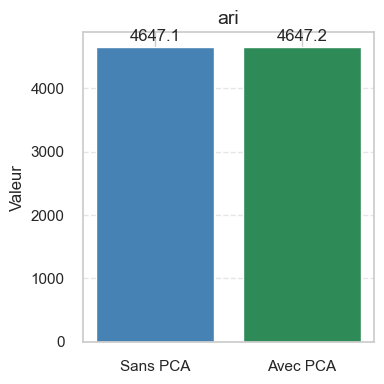

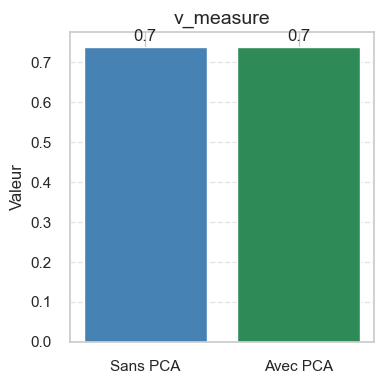

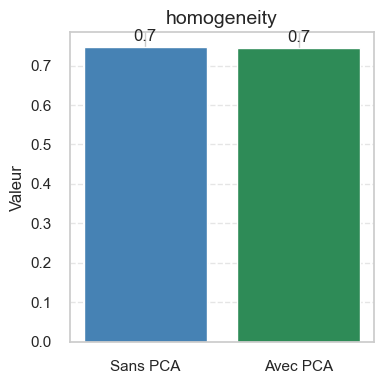

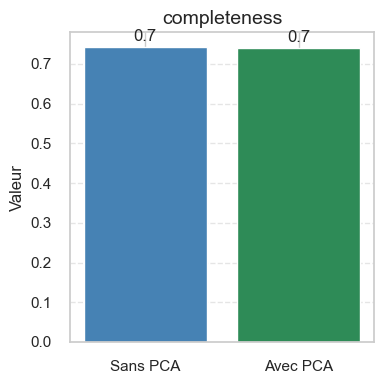

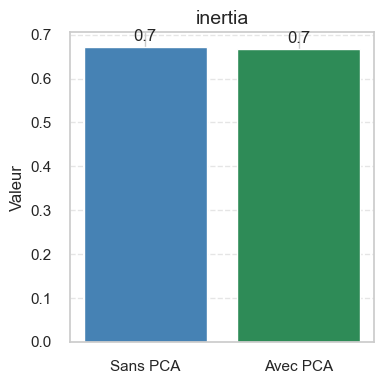

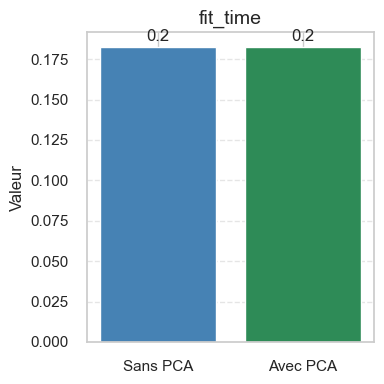

In [220]:
df = pd.DataFrame({"Sans PCA": best_silhouette_config, "Avec PCA": best_silhouette_config_pca})
df_numeric = df.drop(index="init")  # supprimer le champ non numérique
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')  # Convertir


#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans PCA", "Avec PCA"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Globalement l'analyse en composante principale permet d'avoir de meilleurs performances , même silhouette score à bondit d'environ 10%.
Le probleme viens peut-être de la méthode k-mean en elle même.
sans pca  la tolerence est nulle ce qui constitue la condition d'arret la plus stricte possible mais même malgrés cela les metriques sont pas bonnes

# Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)

Avec standardisation on peut tester d'autres metriques, on pourra ecrire une fonction qui prend la methode de standardisation en arument
En attendant nous restons avec ce qui a deja été fait, examinons à present le cas de non standardisation
Un meilleur travail consistait à anticiper les questions  en creant des fonctions avec pleins de parametres afin d'eviter de copier coller du code mais bon ...


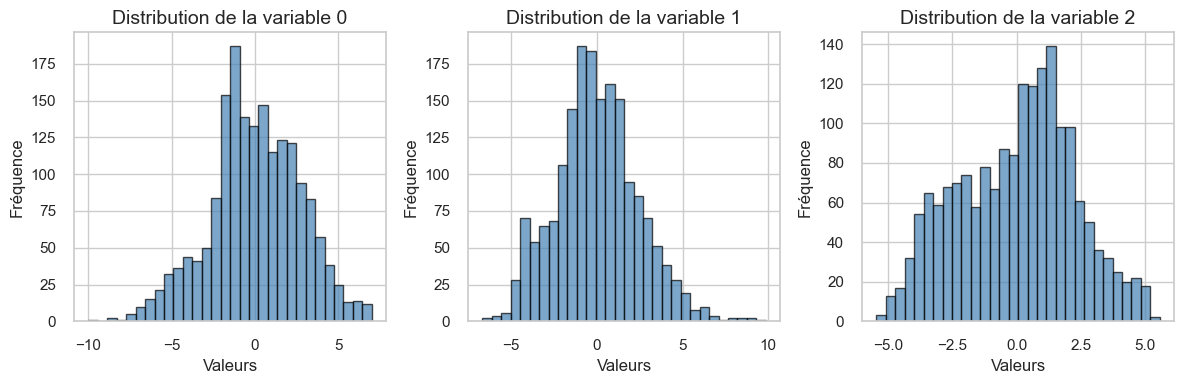

In [221]:

# Sélectionner quelques variables de X_scaled
variables = [0, 1, 2]  

plt.figure(figsize=(12, 4))

for i, var in enumerate(variables, 1):
    plt.subplot(1, len(variables), i)
    plt.hist(X_pca[:, var], bins=30, alpha=0.7, color="steelblue", edgecolor="black")
    plt.title(f"Distribution de la variable {var}")
    plt.xlabel("Valeurs")
    plt.ylabel("Fréquence")
    
plt.tight_layout()
plt.show()

> clairement  pas de standardisation

In [222]:

# Standardisation= False
X_scaled = X_pca  #  sans standardisation
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=221, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.064s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.037s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.051s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.066s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.049s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.070s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.111s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.090s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.108s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.103s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-me

In [223]:
#copier_coller

def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)



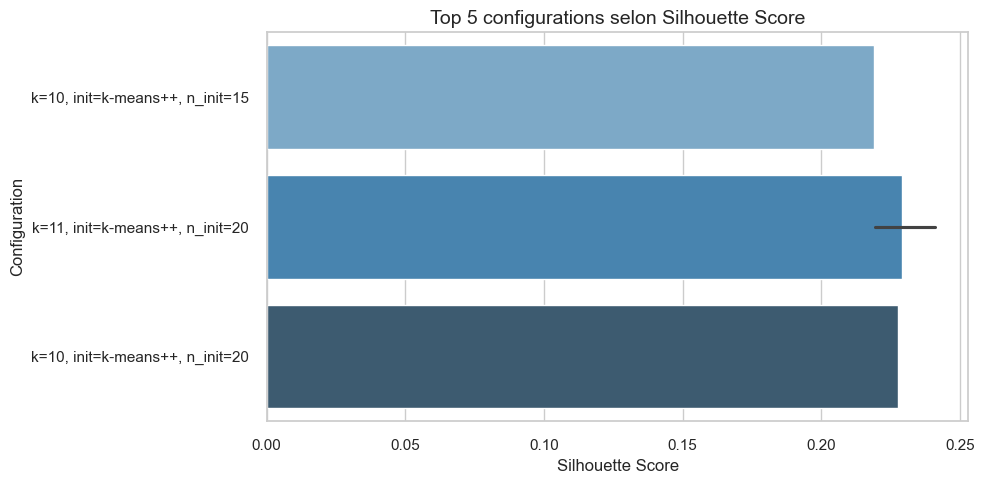

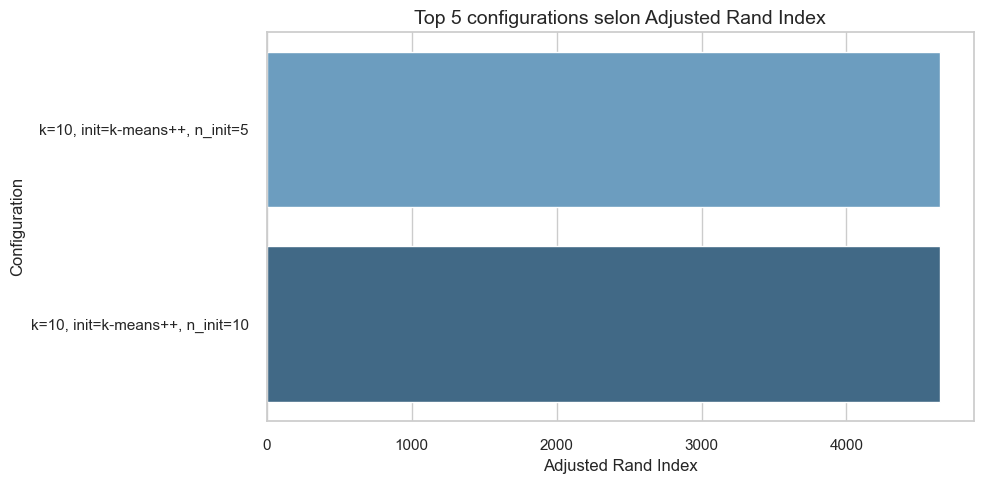

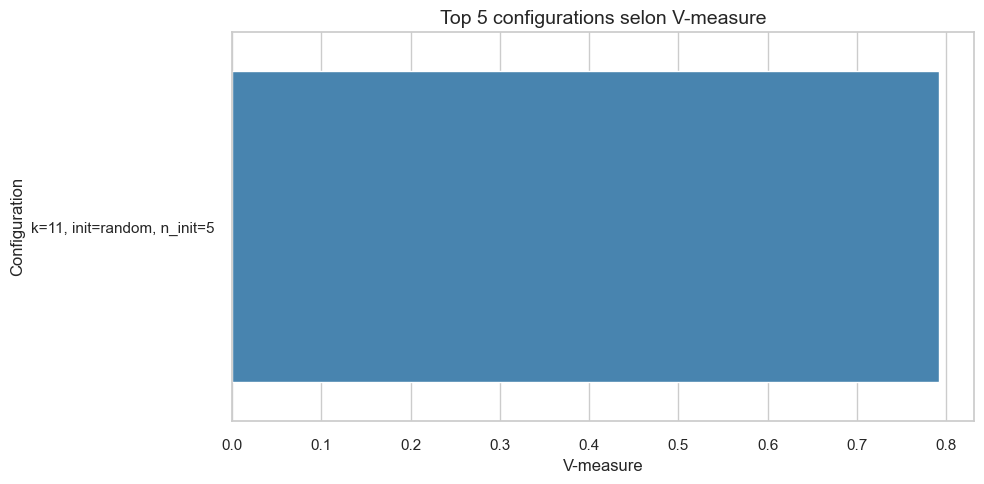

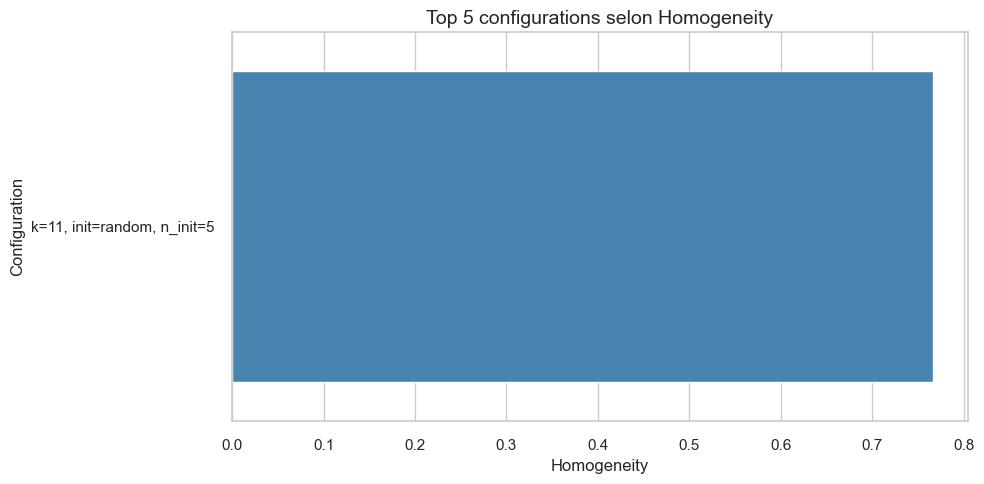

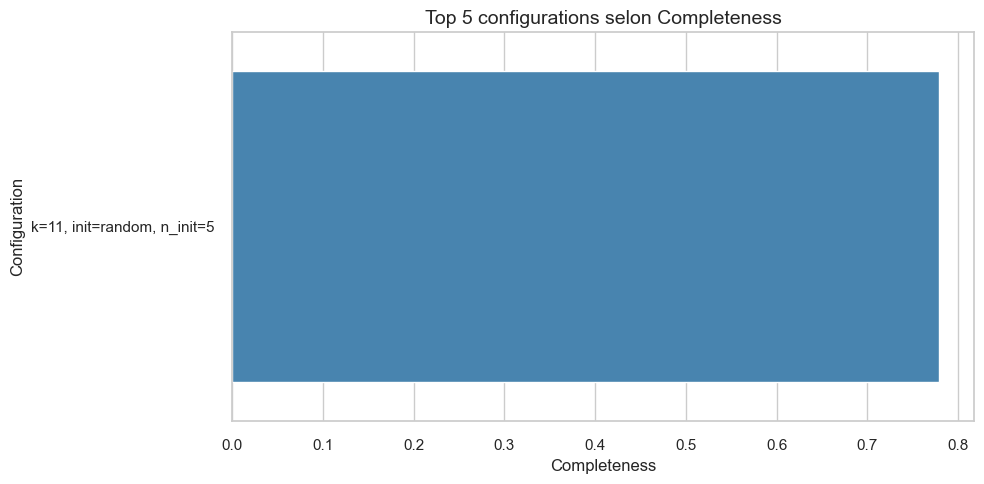

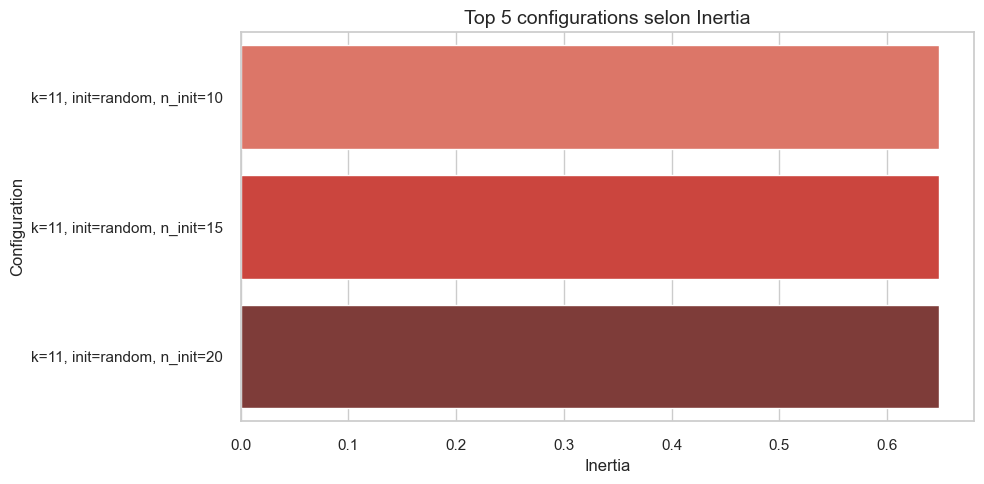

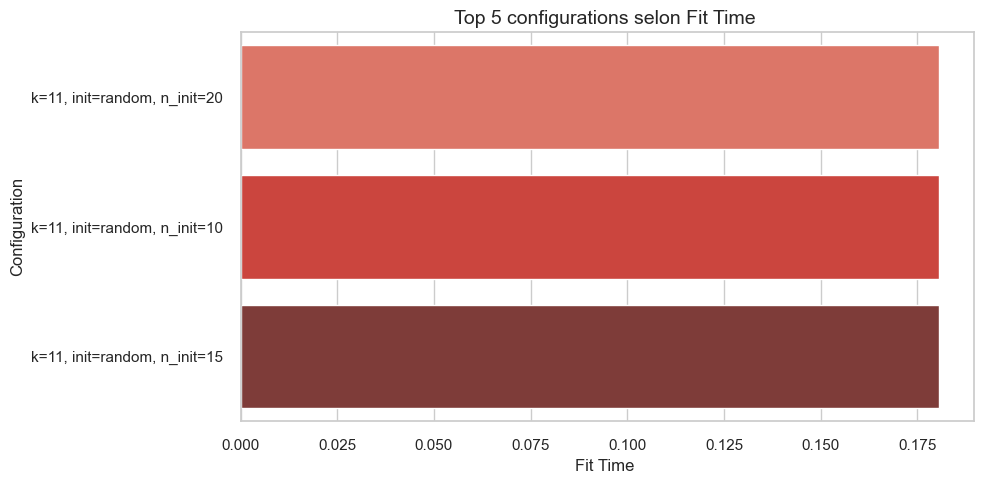

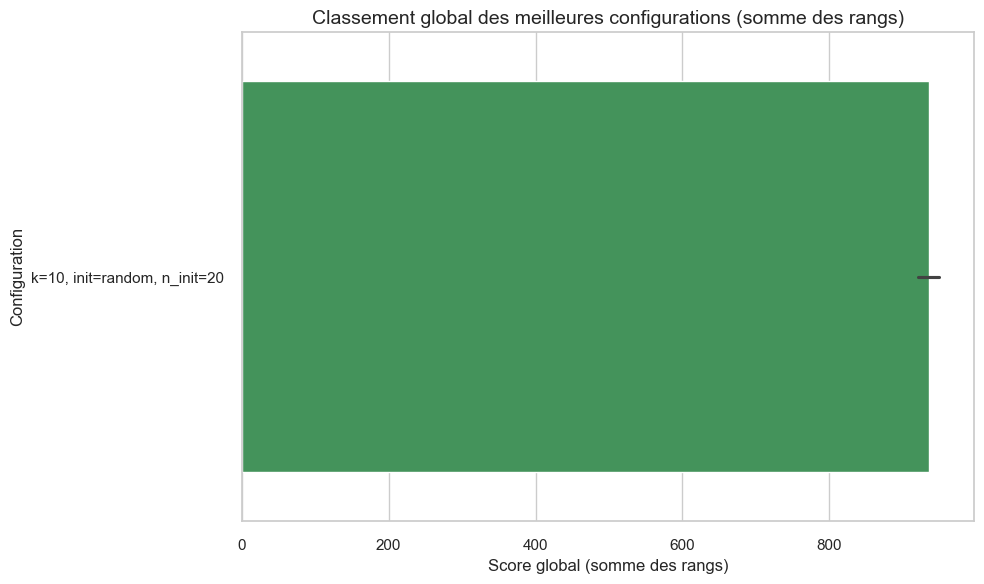

In [224]:
# Si il y a des exequo alors seul le premier est affiche ce qui fait qu'on a pas systematiquement 5 graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
params_df = df["params"].apply(pd.Series)
df_viz = pd.concat([params_df, results_df], axis=1)

# afficher les top configurations
def plot_top_configs(metric, label, ascending):
    threshold = df_viz[metric].sort_values(ascending=ascending).iloc[top_n - 1]
    if ascending:
        top_df = df_viz[df_viz[metric] <= threshold].copy()
    else:
        top_df = df_viz[df_viz[metric] >= threshold].copy()

    top_df["config"] = top_df.apply(
        lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
    )
    
    # Tracé
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_df,
        y="config",
        hue="config",
        x=metric,
        palette="Blues_d" if not ascending else "Reds_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()

for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [225]:
best_silhouette_config_no_standard = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config_no_standard


init                                                    k-means++
max_iter                                                      400
n_clusters                                                     11
n_init                                                         20
tol                                                         0.001
name            k=11, init=k-means++, n_init=20, max_iter=400,...
silhouette                                               0.240981
ari                                                   4516.478776
v_measure                                                0.781971
homogeneity                                              0.758592
completeness                                             0.770104
inertia                                                  0.718593
fit_time                                                 0.183178
Name: 155, dtype: object

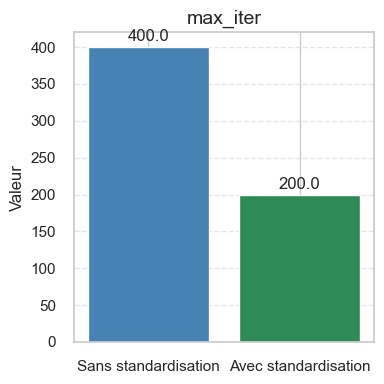

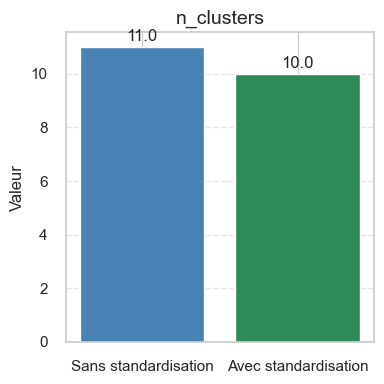

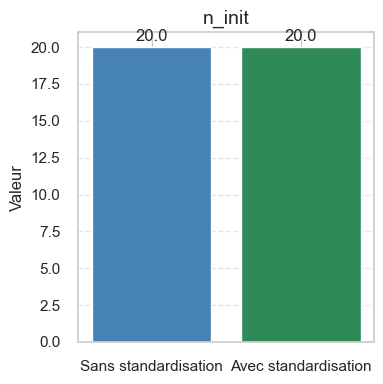

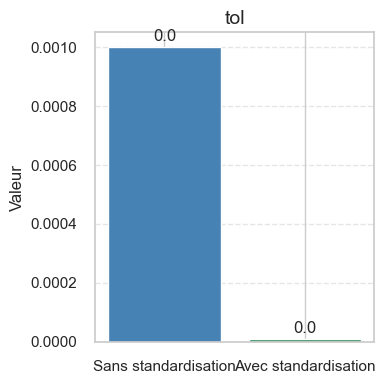

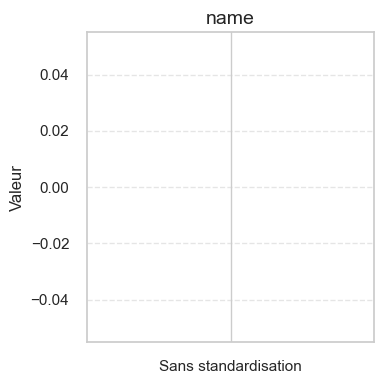

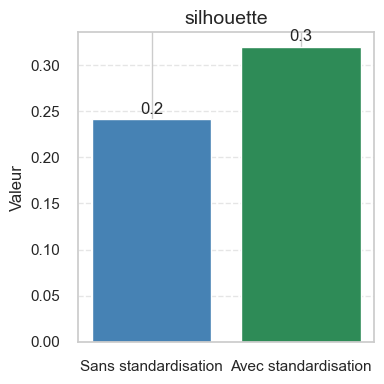

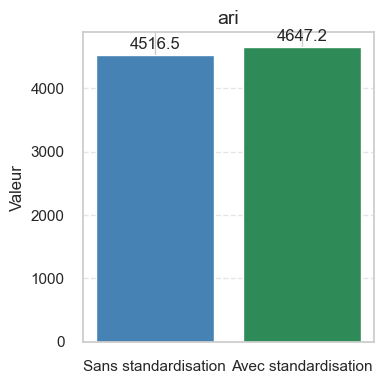

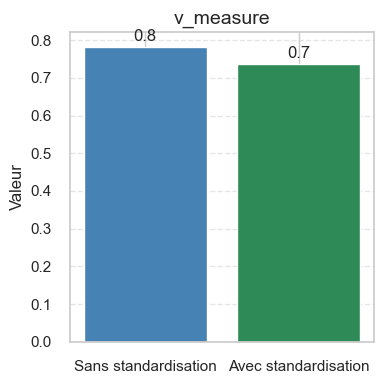

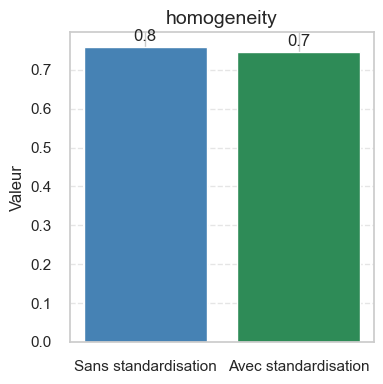

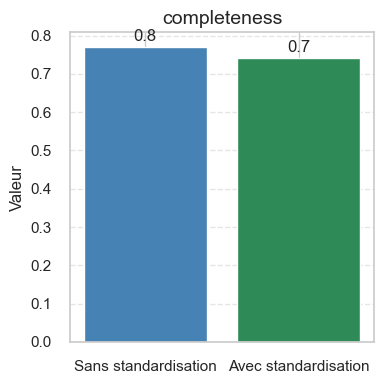

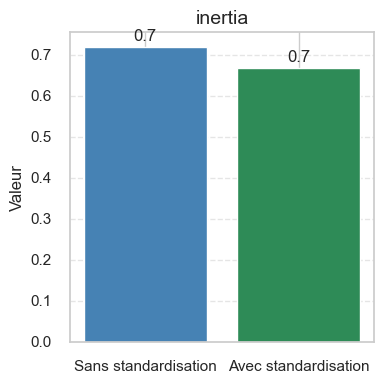

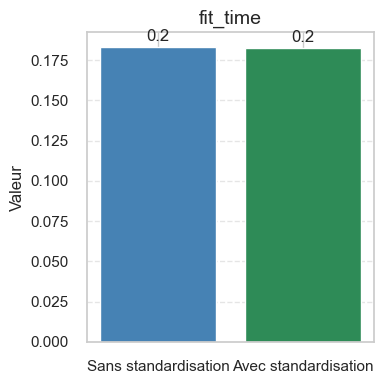

In [226]:
df = pd.DataFrame({"Sans standardisation": best_silhouette_config_no_standard, "Avec standardisation": best_silhouette_config_pca})
df_numeric = df.drop(index="init")  # supprimer le champ non numérique
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')  # Convertir


#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans standardisation", "Avec standardisation"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Environ deux fois plus d'iteration pour un score bien inferieure conclusion: k-means est tres sensible à la standardisation donc toujours en faire